In [1]:
#Importing Necessary Packages

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random

# Importing Income Data

In [4]:
##### Import Data

raw_data = pd.read_csv('Data/Ethiopia_S8a.csv', sep=',')
raw_data.fillna(0, inplace=True)
raw_data.loc[raw_data['hhid'] == 105][0:40]

raw_data['s7q5d']


0       Petty trading (e.g. charcoal trading)
1                                Casual labor
2                                Casual labor
3                           Livestock keeping
4       Petty trading (e.g. charcoal trading)
                        ...                  
2043                        Livestock keeping
2044                        Livestock keeping
2045                                 Food Aid
2046                             Casual labor
2047                        Livestock trading
Name: s7q5d, Length: 2048, dtype: object

In [20]:
#Keeping only income from agricultural activities
agcolumns = ['Sale of livestock', 'Sale of livestock products', 'Sale of crop']

ag_income = raw_data.loc[raw_data['income_category'].isin(agcolumns)]



In [21]:
#Cleaning Data


incomes = ag_income[['hhid', 'round', 's8q5b', 's8q5a', 's8q5d', 's8q5c', 'income_category']]

grouped_incomes = incomes.groupby(['hhid', 'round']).sum().reset_index()
grouped_incomes['Long'] = grouped_incomes['s8q5a'] + grouped_incomes['s8q5b']
grouped_incomes['Short'] = grouped_incomes['s8q5c'] + grouped_incomes['s8q5d']
grouped_incomes['Total'] = grouped_incomes['s8q5b'] + grouped_incomes['s8q5a'] + grouped_incomes['s8q5d'] + grouped_incomes['s8q5c']

grouped_incomes



,hhid,round,s8q5b,s8q5a,s8q5d,s8q5c,Long,Short,Total
0,101,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101,3,0.0,5000.0,3000.0,100.0,5000.0,3100.0,8100.0
3,101,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,102,1,4500.0,2500.0,1000.0,0.0,7000.0,1000.0,8000.0
...,...,...,...,...,...,...,...,...,...
2043,1745,3,100.0,0.0,6100.0,3700.0,100.0,9800.0,9900.0
2044,1745,4,200.0,1250.0,140.0,9805.0,1450.0,9945.0,11395.0
2045,1750,2,0.0,3200.0,0.0,0.0,3200.0,0.0,3200.0
2046,1750,3,1170.0,0.0,3700.0,0.0,1170.0,3700.0,4870.0


# Cash Transfer Data

In [36]:
raw_transfer_data = pd.read_csv('Data/Ethiopia_S9a.csv', sep=',')
raw_transfer_data.fillna(0, inplace=True)
raw_transfer_data.loc[raw_transfer_data['hhid'] == 105][0:40]

,hhid,round,comment,type,direction,transferid,s9q2c,s9q2a,s9q3b,s9q2b,s9q5b,s9q4b
34,105,3,0,Cash,Given,1,Relatives outside household,0,0,150,0,200
35,105,3,0,Cash,Received,1,Relatives outside household,0,670,0,500,0
36,105,3,0,Cash,Received,2,Neighbor/friend,0,45,0,0,0
37,105,3,0,In-kind,Given,1,Relatives outside household,0,0,300,0,0
38,105,3,0,In-kind,Received,1,Relatives outside household,0,0,80,0,220
39,105,4,0,Cash,Given,1,Neighbor/friend,0,100,30,0,120
40,105,4,0,Cash,Received,1,Neighbor/friend,0,50,100,300,0
41,105,4,0,In-kind,Given,1,Neighbor/friend,0,40,100,0,70
42,105,4,0,In-kind,Received,1,Relatives outside household,0,0,200,0,0


In [39]:
#Grouping by hhid and round

raw_transfer_data_short = raw_transfer_data[['hhid', 'round', 's9q3b', 's9q2b', 's9q5b', 's9q4b']]

transfer_narrow = raw_transfer_data_short.groupby(['hhid', 'round']).sum().reset_index()

transfer_narrow['TotalTransfers'] = transfer_narrow['s9q3b'] + transfer_narrow['s9q2b'] + transfer_narrow['s9q4b'] + transfer_narrow['s9q5b']

transfer_narrow


,hhid,round,s9q3b,s9q2b,s9q5b,s9q4b,TotalTransfers
0,101,2,200,850,650,0,1700
1,101,3,555,250,135,20,960
2,101,4,300,50,130,200,680
3,102,1,660,900,300,1000,2860
4,102,2,5150,3200,4150,3100,15600
...,...,...,...,...,...,...,...
1840,1745,3,350,720,400,1030,2500
1841,1745,4,200,0,50,2500,2750
1842,1750,2,210,630,130,60,1030
1843,1750,3,720,300,400,1150,2570


In [49]:
#Official Assitance Transfers
official_assistance = pd.read_csv('Data/Ethiopia_S9b.csv', sep=',')
official_assistance.fillna(0, inplace=True)
official_assistance.loc[official_assistance['hhid'] == 105][0:40]

,hhid,round,comment,s9q6a,s9q6b,s9q6c,s9q7a,s9q7b,s9q7c,s9q8a,...,s9q15a,s9q15c,s9q15b,s9q15e,s9q15d,s9q16a,s9q16c,s9q16b,s9q16e,s9q16d
9,105,1,0,Yes,5.0,250.0,No,0.0,0.0,No,...,Yes,500.0,500.0,500.0,250.0,No,0.0,0.0,0.0,0.0
10,105,2,0,Yes,2.0,400.0,No,0.0,0.0,No,...,No,0.0,0.0,0.0,0.0,No,0.0,0.0,0.0,0.0
11,105,3,0,No,0.0,0.0,Yes,9.0,300.0,No,...,No,0.0,0.0,0.0,0.0,No,0.0,0.0,0.0,0.0
12,105,4,0,Yes,2.0,420.0,No,0.0,0.0,No,...,No,0.0,0.0,0.0,0.0,No,0.0,0.0,0.0,0.0


In [52]:
#Grouping by hhid and round

official_narrow = official_assistance[['hhid', 'round', 's9q14b', 's9q14c', 's9q14d', 's9q14e','s9q15b', 's9q15c', 's9q15d', 's9q15e', 's9q16b', 's9q16c', 's9q16d', 's9q16e']]

official_short = official_narrow.groupby(['hhid', 'round']).sum().reset_index()

official_short['TotalAssistance'] = official_short['s9q14b'] + official_short['s9q14c'] + official_short['s9q14d'] + official_short['s9q14e'] + official_short['s9q15b'] + official_short['s9q15c'] + official_short['s9q15d'] + official_short['s9q15e'] + official_short['s9q16b'] + official_short['s9q16c'] + official_short['s9q16d'] + official_short['s9q16e']

official_short

,hhid,round,s9q14b,s9q14c,s9q14d,s9q14e,s9q15b,s9q15c,s9q15d,s9q15e,s9q16b,s9q16c,s9q16d,s9q16e,TotalAssistance
0,101,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101,2,250.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,750.0
2,101,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,102,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,1745,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2044,1745,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2045,1750,2,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0
2046,1750,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Consumption Analysis

In [26]:
ag_consump = pd.read_csv('Data/Ethiopia_S12A.csv', sep=',')
other_consump = pd.read_csv('Data/Ethiopia_S12B.csv', sep=',')
livestock_consump = pd.read_csv('Data/Ethiopia_S12C.csv', sep=',')

ag_consump

,hhid,round,comment,foodclass,foodtype,s11q2,s11q3,s11q4a,s11q4b,s11q5a,s11q6a,s11q6b
0,101,1,0,CEREALS,Teff flour,No,NaN,NaN,NaN,NaN,NaN,NaN
1,101,1,0,CEREALS,Bread,No,NaN,NaN,NaN,NaN,NaN,NaN
2,101,1,0,CEREALS,"Other grains (sorghum, millet, other types)",No,NaN,NaN,NaN,NaN,NaN,NaN
3,101,1,0,CEREALS,Pasta - pre-packed,Yes,2.0,PACKET - 500 GRAM,NaN,13.0,PURCHASE,NaN
4,101,1,0,CEREALS,Pasta - loose (macaroni),Yes,2.0,KILOGRAM,NaN,10.0,PURCHASE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
120260,1750,4,0,WILD FOOD,Fruit/berry,No,NaN,NaN,NaN,NaN,NaN,NaN
120261,1750,4,0,WILD FOOD,Leaf/flower,No,NaN,NaN,NaN,NaN,NaN,NaN
120262,1750,4,0,SUPPLEMENTARY FEED,Plump nuts,No,NaN,NaN,NaN,NaN,NaN,NaN
120263,1750,4,0,SUPPLEMENTARY FEED,"Fafa (famix, CSB)",No,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#Adding Total consumption expenditures for each of three categories

ag_consump['AgTotal'] = ag_consump['s11q3'] * ag_consump['s11q5a'] * 52 #Consumption per week

other_consump['OtherTotal'] = other_consump['s11q8']

for h in range(len(other_consump)):
    if other_consump['interval'][h] == 'Monthly':
        other_consump['OtherTotal'] = other_consump['s11q8'] * 12
    elif other_consump['interval'][h] == 'Quarterly (3 months)':
        other_consump['OtherTotal'] = other_consump['s11q8'] * 4
        
livestock_consump['LivestockTotal'] = livestock_consump['s11q11']

ag_consump_short = ag_consump[['hhid', 'round', 'AgTotal']]
other_consump_short = other_consump[['hhid', 'round', 'OtherTotal']]
livestock_consump_short = livestock_consump[['hhid', 'round', 'LivestockTotal']]

ag_consump_narrow = ag_consump_short.groupby(['hhid', 'round']).sum().reset_index()
other_consump_narrow = other_consump_short.groupby(['hhid', 'round']).sum().reset_index()
livestock_consump_narrow = livestock_consump_short.groupby(['hhid', 'round']).sum().reset_index()

livestock_consump_narrow

,hhid,round,LivestockTotal
0,101,1,0
1,101,2,1035
2,101,3,900
3,101,4,150
4,102,1,3620
...,...,...,...
2040,1745,3,1860
2041,1745,4,1900
2042,1750,2,200
2043,1750,3,503


In [28]:
#Creating grand total annual consumption by hh. Leaving out agricultural purchases because unclear how often per year these are made
merge1 = pd.merge(ag_consump_narrow, other_consump_narrow, on = ['hhid', 'round'])
total_consump_narrow = pd.merge(merge1, livestock_consump_narrow, on=['hhid', 'round'])

total_consump_narrow['TotalConsump'] = total_consump_narrow['OtherTotal'] + total_consump_narrow['LivestockTotal']

total_consump_narrow



,hhid,round,AgTotal,OtherTotal,LivestockTotal,TotalConsump
0,101,1,17914.0,12224.0,0,12224.0
1,101,2,11440.0,22760.0,1035,23795.0
2,101,3,23764.0,8808.0,900,9708.0
3,101,4,17732.0,5760.0,150,5910.0
4,102,1,49972.0,36224.0,3620,39844.0
...,...,...,...,...,...,...
2040,1745,3,22412.0,28736.0,1860,30596.0
2041,1745,4,41132.0,13420.0,1900,15320.0
2042,1750,2,15288.0,14624.0,200,14824.0
2043,1750,3,25012.0,14876.0,503,15379.0


# Calculating Consumption as Proportion of Income

In [29]:
#Collecting total incomes
total_incomes = raw_data[['hhid', 'round', 's8q5b', 's8q5a', 's8q5d', 's8q5c']]
total_incomes_narrow = total_incomes.groupby(['hhid', 'round']).sum().reset_index()

total_incomes_narrow['TotalIncome'] = total_incomes_narrow['s8q5b'] + total_incomes_narrow['s8q5a'] + total_incomes_narrow['s8q5d'] + total_incomes_narrow['s8q5c']

total_incomes_narrow


,hhid,round,s8q5b,s8q5a,s8q5d,s8q5c,TotalIncome
0,101,1,3000.0,4000.0,2000.0,3000.0,12000.0
1,101,2,500.0,0.0,500.0,500.0,1500.0
2,101,3,3000.0,9000.0,9000.0,5100.0,26100.0
3,101,4,0.0,2000.0,0.0,1800.0,3800.0
4,102,1,4800.0,2800.0,1300.0,300.0,9200.0
...,...,...,...,...,...,...,...
2043,1745,3,3100.0,4000.0,8100.0,6700.0,21900.0
2044,1745,4,800.0,1250.0,140.0,10505.0,12695.0
2045,1750,2,0.0,3200.0,0.0,0.0,3200.0
2046,1750,3,4070.0,2500.0,5500.0,0.0,12070.0


In [53]:
#Merging Incomes and Consumption

merge1 = pd.merge(total_incomes_narrow, total_consump_narrow, on=['hhid', 'round'])
merge2 = pd.merge(merge1, official_short, on=['hhid', 'round'])
merged_income_consump = pd.merge(merge2, transfer_narrow, on=['hhid', 'round'])
merged_income_consump['TotalResources'] = merged_income_consump['TotalIncome'] + merged_income_consump['TotalTransfers'] + merged_income_consump['TotalAssistance']
merged_income_consump['ConsumpProp'] = merged_income_consump['TotalConsump'] / merged_income_consump['TotalResources']

merged_income_consump.replace([np.inf, -np.inf], np.nan, inplace=True)

merged_income_consump.dropna()

merged_income_consump

,hhid,round,s8q5b,s8q5a,s8q5d,s8q5c,TotalIncome,AgTotal,OtherTotal,LivestockTotal,...,s9q16d,s9q16e,TotalAssistance,s9q3b,s9q2b,s9q5b,s9q4b,TotalTransfers,TotalResources,ConsumpProp
0,101,2,500.0,0.0,500.0,500.0,1500.0,11440.0,22760.0,1035,...,0.0,0.0,750.0,200,850,650,0,1700,3950.0,6.024051
1,101,3,3000.0,9000.0,9000.0,5100.0,26100.0,23764.0,8808.0,900,...,0.0,0.0,0.0,555,250,135,20,960,27060.0,0.358758
2,101,4,0.0,2000.0,0.0,1800.0,3800.0,17732.0,5760.0,150,...,0.0,0.0,0.0,300,50,130,200,680,4480.0,1.319196
3,102,1,4800.0,2800.0,1300.0,300.0,9200.0,49972.0,36224.0,3620,...,0.0,0.0,0.0,660,900,300,1000,2860,12060.0,3.303814
4,102,2,2040.0,2000.0,1700.0,1500.0,7240.0,51584.0,77912.0,1550,...,0.0,0.0,0.0,5150,3200,4150,3100,15600,22840.0,3.479072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,1745,3,3100.0,4000.0,8100.0,6700.0,21900.0,22412.0,28736.0,1860,...,0.0,0.0,0.0,350,720,400,1030,2500,24400.0,1.253934
1839,1745,4,800.0,1250.0,140.0,10505.0,12695.0,41132.0,13420.0,1900,...,0.0,0.0,0.0,200,0,50,2500,2750,15445.0,0.991907
1840,1750,2,0.0,3200.0,0.0,0.0,3200.0,15288.0,14624.0,200,...,0.0,0.0,200.0,210,630,130,60,1030,4430.0,3.346275
1841,1750,3,4070.0,2500.0,5500.0,0.0,12070.0,25012.0,14876.0,503,...,0.0,0.0,0.0,720,300,400,1150,2570,14640.0,1.050478


In [55]:
#Selecting only those that are above a consumption threshold
consump_thresh = 84.43 * 52.7 #84.43 USD is security threshold in Nepal case, 52.7 is conversion USD to Birr

secure_consump = merged_income_consump.loc[merged_income_consump['ConsumpProp'] < 1]

secure_consump['ConsumpProp'].describe()


count    942.000000
mean       0.570549
std        0.242660
min        0.020373
25%        0.386234
50%        0.571411
75%        0.771795
max        0.997862
Name: ConsumpProp, dtype: float64

grouped_pivot = pd.pivot(grouped_incomes, index='hhid', columns = 'round', values = ['s8q5a', 's8q5b', 's8q5c', 's8q5d']).reset_index()
grouped_pivot = grouped_pivot.dropna()

grouped_pivot



In [18]:
#Adding income description to dataframe
yearly_incomes = grouped_incomes[['hhid', 'round', 'Long', 'Short', 'Total']]

yearly_incomes

yearly_incomes.loc[yearly_incomes['hhid'] == 1736]

pivoted_incomes = pd.pivot(yearly_incomes, index='round', columns='hhid', values=['Total'])

clean_incomes = pivoted_incomes.dropna(axis=1)

clean_incomes

#Dropping households that reported no income for entire survey
for i in clean_incomes.columns:
    if clean_incomes[i].sum() == 0:
        clean_incomes.drop([i], axis=1, inplace=True)
        
clean_incomes

/var/folders/c6/jtn5gdss2tz871flnynkhmx40000gq/T/ipykernel_21303/810752146.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_incomes.drop([i], axis=1, inplace=True)


Total                                                            \
hhid     101     102      105     106      107     108    110      111    
round                                                                     
1         0.0  8000.0  10600.0  5400.0  21000.0  1500.0  400.0   6800.0   
2         0.0  1240.0   6240.0  2330.0  30550.0   400.0    0.0      0.0   
3      8100.0  4150.0   8500.0  7600.0   8850.0     0.0  600.0  14850.0   
4         0.0  1100.0  25480.0  5600.0  11400.0  6500.0  400.0  10000.0   

                         ...                                              \
hhid      112      115   ...     1726     1727     1728     1729    1730   
round                    ...                                               
1      21550.0   2500.0  ...  12550.0   8000.0      0.0      0.0  1700.0   
2       5150.0   7400.0  ...   6508.0   1140.0   1140.0      0.0  1168.0   
3       5300.0   3450.0  ...   8520.0  12500.0   3550.0   1800.0  4140.0   
4       5150.0  10200.0  ...  12500.0  24740.0  10150.0  12430.0  6050.0   

                                                  
hhid     1732     1733     1734    1735     1737  
round                                             
1      1650.0   2320.0   6308.0  1200.0      0.0  
2       240.0  12300.0    896.0   500.0      0.0  
3      2600.0  12890.0  14580.0  5160.0      0.0  
4         0.0   9580.0   5350.0  6450.0  11000.0  

[4 rows x 455 columns]

# Note - think about separating out drought vs non-drought years?

In [11]:
#Calculating correlation matrix

matrix = clean_incomes.corr(method='pearson')
running_corr = []

for i in range(len(matrix)):
    for j in range(len(matrix.columns)):
        if i < j:
            running_corr.append(matrix.iloc[i,j])


p_avg = np.average(running_corr)
print(p_avg)

matrix


0.0841842674387968


Total                                                    \
hhid            101       102       105       106       107       108    
      hhid                                                               
Total 101   1.000000  0.108561 -0.322194  0.725650 -0.613061 -0.466494   
      102   0.108561  1.000000 -0.334162  0.377071 -0.051431 -0.369725   
      105  -0.322194 -0.334162  1.000000  0.231647 -0.516027  0.986700   
      106   0.725650  0.377071  0.231647  1.000000 -0.929391  0.075525   
      107  -0.613061 -0.051431 -0.516027 -0.929391  1.000000 -0.369945   
...              ...       ...       ...       ...       ...       ...   
      1732  0.804242  0.674041 -0.499168  0.717649 -0.429146 -0.621935   
      1733  0.496841 -0.774094 -0.128027 -0.040237 -0.124857 -0.165186   
      1734  0.910662  0.354704 -0.080773  0.938170 -0.809670 -0.241033   
      1735  0.417972 -0.333980  0.720151  0.699263 -0.913250  0.607022   
      1737 -0.333333 -0.519138  0.978841  0.112641 -0.441269  0.977416   

                                                    ...                      \
hhid            110       111       112       115   ...      1726      1727   
      hhid                                          ...                       
Total 101   0.662266  0.742716 -0.325166 -0.454783  ... -0.332390  0.060756   
      102   0.432809  0.204499  0.904619 -0.881134  ...  0.424105 -0.243605   
      105   0.265644  0.313713 -0.164731  0.672202  ...  0.705309  0.923125   
      106   0.995350  0.983711  0.058152 -0.392161  ...  0.406506  0.566636   
      107  -0.918206 -0.973111  0.200473  0.025076  ... -0.438248 -0.804030   
...              ...       ...       ...       ...  ...       ...       ...   
      1732  0.701331  0.625121  0.295378 -0.880813  ... -0.051232 -0.166852   
      1733 -0.133026  0.104962 -0.953209  0.396662  ... -0.750902  0.004548   
      1734  0.908375  0.921070 -0.047354 -0.530878  ...  0.082026  0.302734   
      1735  0.678615  0.805280 -0.482889  0.380751  ...  0.361855  0.917751   
      1737  0.132453  0.223484 -0.337398  0.804616  ...  0.549845  0.882472   

                                                                        \
hhid            1728      1729      1730      1732      1733      1734   
      hhid                                                               
Total 101  -0.023489 -0.196077  0.257875  0.804242  0.496841  0.910662   
      102  -0.599269 -0.523590 -0.382728  0.674041 -0.774094  0.354704   
      105   0.905784  0.969538  0.825173 -0.499168 -0.128027 -0.080773   
      106   0.297847  0.226447  0.603936  0.717649 -0.040237  0.938170   
      107  -0.626213 -0.551286 -0.854253 -0.429146 -0.124857 -0.809670   
...              ...       ...       ...       ...       ...       ...   
      1732 -0.428769 -0.514360 -0.097194  1.000000 -0.075107  0.861819   
      1733  0.293585  0.118757  0.259524 -0.075107  1.000000  0.159355   
      1734  0.082510 -0.036990  0.410783  0.861819  0.159355  1.000000   
      1735  0.878340  0.803697  0.985488  0.053591  0.324709  0.548874   
      1737  0.945413  0.989867  0.820459 -0.611007  0.042233 -0.167438   

                                
hhid            1735      1737  
      hhid                      
Total 101   0.417972 -0.333333  
      102  -0.333980 -0.519138  
      105   0.720151  0.978841  
      106   0.699263  0.112641  
      107  -0.913250 -0.441269  
...              ...       ...  
      1732  0.053591 -0.611007  
      1733  0.324709  0.042233  
      1734  0.548874 -0.167438  
      1735  1.000000  0.712206  
      1737  0.712206  1.000000  

[455 rows x 455 columns]

In [12]:
#Bootstrap Correlation Coefficient

#Check for two seasons


samples = 1000 
households = int(len(matrix) /17) #528 total sampled households, 17 Reeras
max_hh = len(matrix)
avg_rho = np.zeros(samples)

for a in range(samples):
    random_households = random.sample(range(0, max_hh), households)
    corr_array = []
    
    for i in random_households:
        for j in random_households:
            if i < j:
                corr_array.append(matrix.iloc[i,j])

    avg_rho[a] = np.average(corr_array)

print('Low CI:', np.percentile(avg_rho, 2.5))
print(np.average(avg_rho))
print('High CI:', np.percentile(avg_rho, 97.5))

Low CI: -0.017639274969002885
0.08310633821868876
High CI: 0.24064416924917992


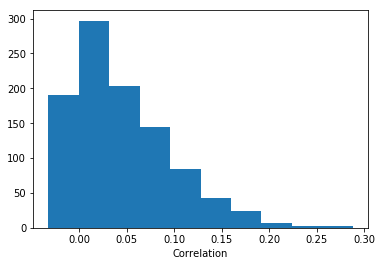

In [28]:
plt.hist(avg_rho)
plt.xlabel('Correlation')
plt.show()